# Understanding LangGraph

LangGraph is a special LangChain-built library that focuses on building intelligent AI Agents using graphs. Ie, agentic state machines.

We need these prerequisite libraries to run a graph visualization library (`pygraphviz`). We will use this library during this notebook to understand the structure of our graphs _but_ it is not required to use `langgraph`.

We need a few libraries from LangChain:

In [2]:
!pip install -qU \
    langchain-openai==0.1.3 \
    langchain==0.1.16 \
    langchain-core==0.1.42 \
    langgraph==0.0.37 \
    langchainhub==0.1.15 \
    pygraphviz==1.12  # for visualizing

## Graph State
**Graph State in LangGraph**

In LangGraph, the **state** is a central data structure that represents the current snapshot of your application. It's essentially a shared memory area that's passed around between different nodes in the graph as they execute.

**Key points about graph state:**

* **Data structure:** It can be any Python type, but typically it's a `TypedDict` or a `Pydantic BaseModel` for better structure and type safety.
* **Updates:** Each node in the graph can update the state with its return value after execution. The way the state is updated depends on the graph type or custom functions.
* **Sharing:** The state is shared among all nodes in the graph, allowing them to access and modify it as needed.
* **Persistence:** The state can be persisted using a checkpointer, enabling you to save and restore the graph's state at different points in time.

**Example:**

Imagine a graph representing a simple chatbot. The state could be a `TypedDict` with keys like `user_query`, `bot_response`, and `conversation_history`. As the chatbot interacts with the user, different nodes update the state with new information.



--

We will define a custom graph state to support our agent-oriented decision making. In this we will define:

* our user `input` (ie the most recent message from the user)
* `agent_out` which is used by the graph (and our final output) to consume/output agent outputs
* `intermediate_steps` which is a list maintained over our graph runtime to keep track of the results of previous steps

During each step in our graph we will be able to add to, modify, or extract these values from our state object.

In [3]:
from typing import TypedDict, Annotated, List, Union
from langchain_core.agents import AgentAction, AgentFinish
import operator



    
# Agent state tracking input, output, and intermediate steps

class AgentState(TypedDict):
    """
    Represents the state of an agent during its execution.

    Attributes:
        input (str): The input provided to the agent.
        agent_out (Union[AgentAction, AgentFinish, None]): The output of the agent, which can be an action, a finish, or None.
        intermediate_steps (Annotated[list[tuple[AgentAction, str]], operator.add]): A list of intermediate steps taken by the agent, where each step is a tuple of (AgentAction, output).
    """
    
    input: str
    agent_out: Union[AgentAction, AgentFinish, None]
    intermediate_steps: Annotated[list[tuple[AgentAction, str]], operator.add]

## Emulate Search

To test a RAG-like agent we'll provide a tool that provide information as we would expect a search tool in a RAG agent to do.

In [4]:
ehi_information = """Title: EHI: End-to-end Learning of Hierarchical Index for
Efficient Dense Retrieval
Summary: Dense embedding-based retrieval is now the industry
standard for semantic search and ranking problems, like obtaining relevant web
documents for a given query. Such techniques use a two-stage process: (a)
contrastive learning to train a dual encoder to embed both the query and
documents and (b) approximate nearest neighbor search (ANNS) for finding similar
documents for a given query. These two stages are disjoint; the learned
embeddings might be ill-suited for the ANNS method and vice-versa, leading to
suboptimal performance. In this work, we propose End-to-end Hierarchical
Indexing -- EHI -- that jointly learns both the embeddings and the ANNS
structure to optimize retrieval performance. EHI uses a standard dual encoder
model for embedding queries and documents while learning an inverted file index
(IVF) style tree structure for efficient ANNS. To ensure stable and efficient
learning of discrete tree-based ANNS structure, EHI introduces the notion of
dense path embedding that captures the position of a query/document in the tree.
We demonstrate the effectiveness of EHI on several benchmarks, including
de-facto industry standard MS MARCO (Dev set and TREC DL19) datasets. For
example, with the same compute budget, EHI outperforms state-of-the-art (SOTA)
in by 0.6% (MRR@10) on MS MARCO dev set and by 4.2% (nDCG@10) on TREC DL19
benchmarks.
Author(s): Ramnath Kumar, Anshul Mittal, Nilesh Gupta, Aditya Kusupati,
Inderjit Dhillon, Prateek Jain
Source: https://arxiv.org/pdf/2310.08891.pdf"""

## Custom Tools

We will define two tools for this agent, a `search` tool (which emulates our RAG component) and a `final_answer` tool — which is provides output in a specific format, ie:

```json
{
    "answer": "<LLM generated answer here>",
    "source": "<LLM generated citation here>"
}
```

We define both using the `@tool` decorator from LangChain.

In [5]:
from langchain_core.tools import tool

@tool("search")
def search_tool(query: str):
    """Searches for information on the topic of artificial intelligence (AI).
    Cannot be used to research any other topics. Search query must be provided
    in natural language and be verbose."""
    # this is a "RAG" emulator
    return ehi_information

@tool("final_answer")
def final_answer_tool(
    answer: str,
    source: str
):
    """Returns a natural language response to the user in `answer`, and a
    `source` which provides citations for where this information came from.
    """
    return ""

These tools will be triggered via OpenAI Tools (ie function calling). The LLM will be provided information on the schema (ie structure) of the function to be called, like that which we can see here:

In [6]:
search_tool

StructuredTool(name='search', description='search(query: str) - Searches for information on the topic of artificial intelligence (AI).\n    Cannot be used to research any other topics. Search query must be provided\n    in natural language and be verbose.', args_schema=<class 'pydantic.v1.main.searchSchema'>, func=<function search_tool at 0x78ab50bbe340>)

## Initialize Agent

In [7]:
import os
from langchain.agents import create_openai_tools_agent
from langchain import hub
from langchain_openai import ChatOpenAI

os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY") or "sk-..."

llm = ChatOpenAI(temperature=0)

prompt = hub.pull("hwchase17/openai-functions-agent")

query_agent_runnable = create_openai_tools_agent(
    llm=llm,
    tools=[final_answer_tool, search_tool],
    prompt=prompt
)

Test the agent quickly to confirm it is functional:

In [8]:
inputs = {
    "input": "what are EHI embeddings?",
    "intermediate_steps": []
}
agent_out = query_agent_runnable.invoke(inputs)
agent_out

[ToolAgentAction(tool='search', tool_input={'query': 'EHI embeddings'}, log="\nInvoking: `search` with `{'query': 'EHI embeddings'}`\n\n\n", message_log=[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_IySWmdrGg2xrNTEZ8pCHCZIJ', 'function': {'arguments': '{"query":"EHI embeddings"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 150, 'total_tokens': 165}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-9e09210a-88bd-4873-a8cc-5f3753f9e27a-0', tool_calls=[{'name': 'search', 'args': {'query': 'EHI embeddings'}, 'id': 'call_IySWmdrGg2xrNTEZ8pCHCZIJ'}])], tool_call_id='call_IySWmdrGg2xrNTEZ8pCHCZIJ')]

In [9]:
agent_out[-1].message_log[-1].additional_kwargs["tool_calls"][-1]

{'id': 'call_IySWmdrGg2xrNTEZ8pCHCZIJ',
 'function': {'arguments': '{"query":"EHI embeddings"}', 'name': 'search'},
 'type': 'function'}

The agent won't perform the function calls themselvs, that is up to us and we will handle it in downstream actions through our agent graph.

The information provided by `agent_out` will be used to decide whether we move to the `search` or `END` nodes of our graph. We'll also add a `error` handler node in case our agent fails to produce the output we need.

## Define Nodes for Graph

In [10]:
from langchain_core.agents import AgentFinish
import json

def run_query_agent(state: list):
    print("> run_query_agent")
    agent_out = query_agent_runnable.invoke(state)
    return {"agent_out": agent_out}

def execute_search(state: list):
    print("> execute_search")
    action = state["agent_out"]
    tool_call = action[-1].message_log[-1].additional_kwargs["tool_calls"][-1]
    out = search_tool.invoke(
        json.loads(tool_call["function"]["arguments"])
    )
    return {"intermediate_steps": [{"search": str(out)}]}

def router(state: list):
    print("> router")
    if isinstance(state["agent_out"], list):
        return state["agent_out"][-1].tool
    else:
        return "error"

# finally, we will have a single LLM call that MUST use the final_answer structure
final_answer_llm = llm.bind_tools([final_answer_tool], tool_choice="final_answer")

# this forced final_answer LLM call will be used to structure output from our
# RAG endpoint
def rag_final_answer(state: list):
    print("> final_answer")
    query = state["input"]
    context = state["intermediate_steps"][-1]

    prompt = f"""You are a helpful assistant, answer the user's question using the
    context provided.

    CONTEXT: {context}

    QUESTION: {query}
    """
    out = final_answer_llm.invoke(prompt)
    function_call = out.additional_kwargs["tool_calls"][-1]["function"]["arguments"]
    return {"agent_out": function_call}

# we use the same forced final_answer LLM call to handle incorrectly formatted
# output from our query_agent
def handle_error(state: list):
    print("> handle_error")
    query = state["input"]
    prompt = f"""You are a helpful assistant, answer the user's question.

    QUESTION: {query}
    """
    out = final_answer_llm.invoke(prompt)
    function_call = out.additional_kwargs["tool_calls"][-1]["function"]["arguments"]
    return {"agent_out": function_call}

## Define Graph

Our graph is constructed of **nodes** and **edges**. A node represents a function (one of those we just defined above) whereas an edge allows us to travel from one node to another.

Let's start by initializing our graph using our `AgentState` object and adding our first set of nodes and the graph entry point (ie where the graph begins once called).

In [11]:
from langgraph.graph import StateGraph

graph = StateGraph(AgentState) #agent state class is the schema used here to define the graph structure

# we have four nodes that will consume our agent state and modify
# our agent state based on some internal process
graph.add_node("query_agent", run_query_agent)
graph.add_node("search", execute_search)
graph.add_node("error", handle_error)
graph.add_node("rag_final_answer", rag_final_answer)

# our graph will always begin with the query agent
graph.set_entry_point("query_agent")

In addition to our nodes we have our "one-way" edges — that is, once node X is called the state must continue to node Y as defined by these edges. We define these using:

```python
graph.add_edge(X, Y)
```

If `X` or `Y` are defined nodes in our graph we pass the name of that node in string format. So, if we want to add an edge that navigates from our `"search"` node to our `"rag_final_answer"` node, we do:

```python
graph.add_edge("search", "rag_final_answer")
```

We will also have an _end node_ in our graph — we have not defined this end node as it is imported as a specific graph object `END`. To use this, we must add edges between our final nodes and the `END` object, like so:

```python
graph.add_edge("rag_final_answer", END)
```

When the `END` node is called, our graph completes.

In [12]:
from langgraph.graph import StateGraph, END

graph = StateGraph(AgentState)

graph.add_node("query_agent", run_query_agent)
graph.add_node("search", execute_search)
graph.add_node("error", handle_error)
graph.add_node("rag_final_answer", rag_final_answer)

graph.set_entry_point("query_agent")

# conditional edges are controlled by our router
graph.add_conditional_edges(
    start_key="query_agent",  # where in graph to start
    condition=router,  # function to determine which node is called
    conditional_edge_mapping={
        "search": "search",
        "error": "error",
        "final_answer": END
    }
)
graph.add_edge("search", "rag_final_answer")
graph.add_edge("error", END)
graph.add_edge("rag_final_answer", END)

runnable = graph.compile()

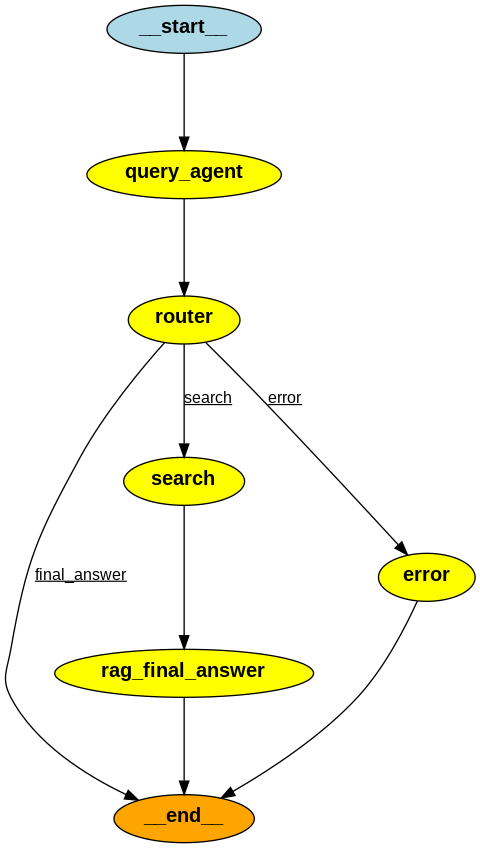

In [13]:
from IPython.display import Image

Image(runnable.get_graph().draw_png())

In [14]:
runnable = graph.compile()

out = runnable.invoke({
    "input": "what is AI?",
    "chat_history": []
})

> run_query_agent
> router
> execute_search
> final_answer


In [15]:
print(out["agent_out"])

{"answer":"AI stands for Artificial Intelligence. It refers to the simulation of human intelligence processes by machines, especially computer systems. AI encompasses tasks such as learning, reasoning, problem-solving, perception, and language understanding.","source":"https://en.wikipedia.org/wiki/Artificial_intelligence"}


In [16]:
out = runnable.invoke({
    "input": "what are EHI embeddings?",
    "chat_history": []
})
print(out["agent_out"])

> run_query_agent
> router
> execute_search
> final_answer
{"answer":"EHI embeddings refer to the embeddings generated by the End-to-end Hierarchical Indexing (EHI) model. These embeddings are learned jointly with the approximate nearest neighbor search (ANNS) structure to optimize retrieval performance in dense embedding-based retrieval for semantic search and ranking problems.","source":"https://arxiv.org/pdf/2310.08891.pdf"}


In [17]:
out = runnable.invoke({
    "input": "can you tell me about EHI embeddings?",
    "chat_history": []
})
print(out["agent_out"])

> run_query_agent
> router
> execute_search
> final_answer
{"answer":"EHI embeddings are part of the End-to-end Hierarchical Indexing (EHI) approach, which jointly learns both embeddings and the approximate nearest neighbor search (ANNS) structure to optimize retrieval performance. EHI uses a standard dual encoder model for embedding queries and documents while learning an inverted file index (IVF) style tree structure for efficient ANNS. To ensure stable and efficient learning of the discrete tree-based ANNS structure, EHI introduces the notion of dense path embedding that captures the position of a query/document in the tree.","source":"https://arxiv.org/pdf/2310.08891.pdf"}


In [18]:
out = runnable.invoke({
    "input": "hi",
    "chat_history": []
})
print(out["agent_out"])

> run_query_agent
> router
> handle_error
{"answer":"Hello! How can I assist you today?","source":""}


In [19]:
out = runnable.invoke({
    "input": "hi, please don't respond to me with a `source`",
    "chat_history": []
})
print(out["agent_out"])

> run_query_agent
> router
> handle_error
{"answer":"Hello! How can I assist you today?","source":"N/A"}
